# Missing Position Prediction - Max-pool Context Result

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentencebert_missingpositionprediction import *

I0529 09:08:54.020690 139835422635840 file_utils.py:41] PyTorch version 1.4.0 available.


In [3]:
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [4]:
device = torch.device('cuda')

## Dataset

In [5]:
# train
train_dataset = ROCStoriesDataset_random_missing(data_path = "../data/rocstories_completion_train.csv")

# dev
val_dataset = ROCStoriesDataset_with_missing(data_path = "../data/rocstories_completion_dev.csv")

# test
test_dataset = ROCStoriesDataset_with_missing(data_path = "../data/rocstories_completion_test.csv")

## Model

In [6]:
%%capture

batch_size = 32
block_size = 32

sentbertmodel = SentenceTransformer('bert-base-nli-mean-tokens')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# --- model --- 
model = MissingPisitionPredictionModel(sentbertmodel, device, ContextEncoder="PoolContextEncoder").to(device)

# --- DataLoader ---|
collate_fn = lambda data: collate(data, tokenizer, block_size=block_size, device=device)
train_iterator = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size, collate_fn=collate_fn,
)    
valid_iterator = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size, collate_fn=collate_fn,
)    
test_iterator = DataLoader(
    test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size, collate_fn=collate_fn,
)    

TRG_PAD_IDX = tokenizer.pad_token_id
START_ID = tokenizer.cls_token_id
mpe_criterion = nn.CrossEntropyLoss()

### load model

In [7]:
model_dir = "<PATH TO model_dir>"
model_name = "sentbert-positionestimation_model.pt"

model_path = os.path.join(model_dir, model_name)

In [8]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Show Result

In [9]:
out = show_result(model, test_iterator)

Iteration: 100%|██████████| 307/307 [04:35<00:00,  1.11it/s]


In [10]:
out.to_csv("result/mpp_maxpool_predict_result_20200421.csv", index=False)

## Heat map

In [9]:
acc_heatmap, cls_count = for_heatmap(model, test_iterator)

Iteration: 100%|██████████| 307/307 [04:15<00:00,  1.20it/s]


In [10]:
acc_heatmap_df = pd.DataFrame(acc_heatmap, 
                              index=['1', '2', '3', '4', '5'], columns=['1', '2', '3', '4', '5'])

In [13]:
sns.set()

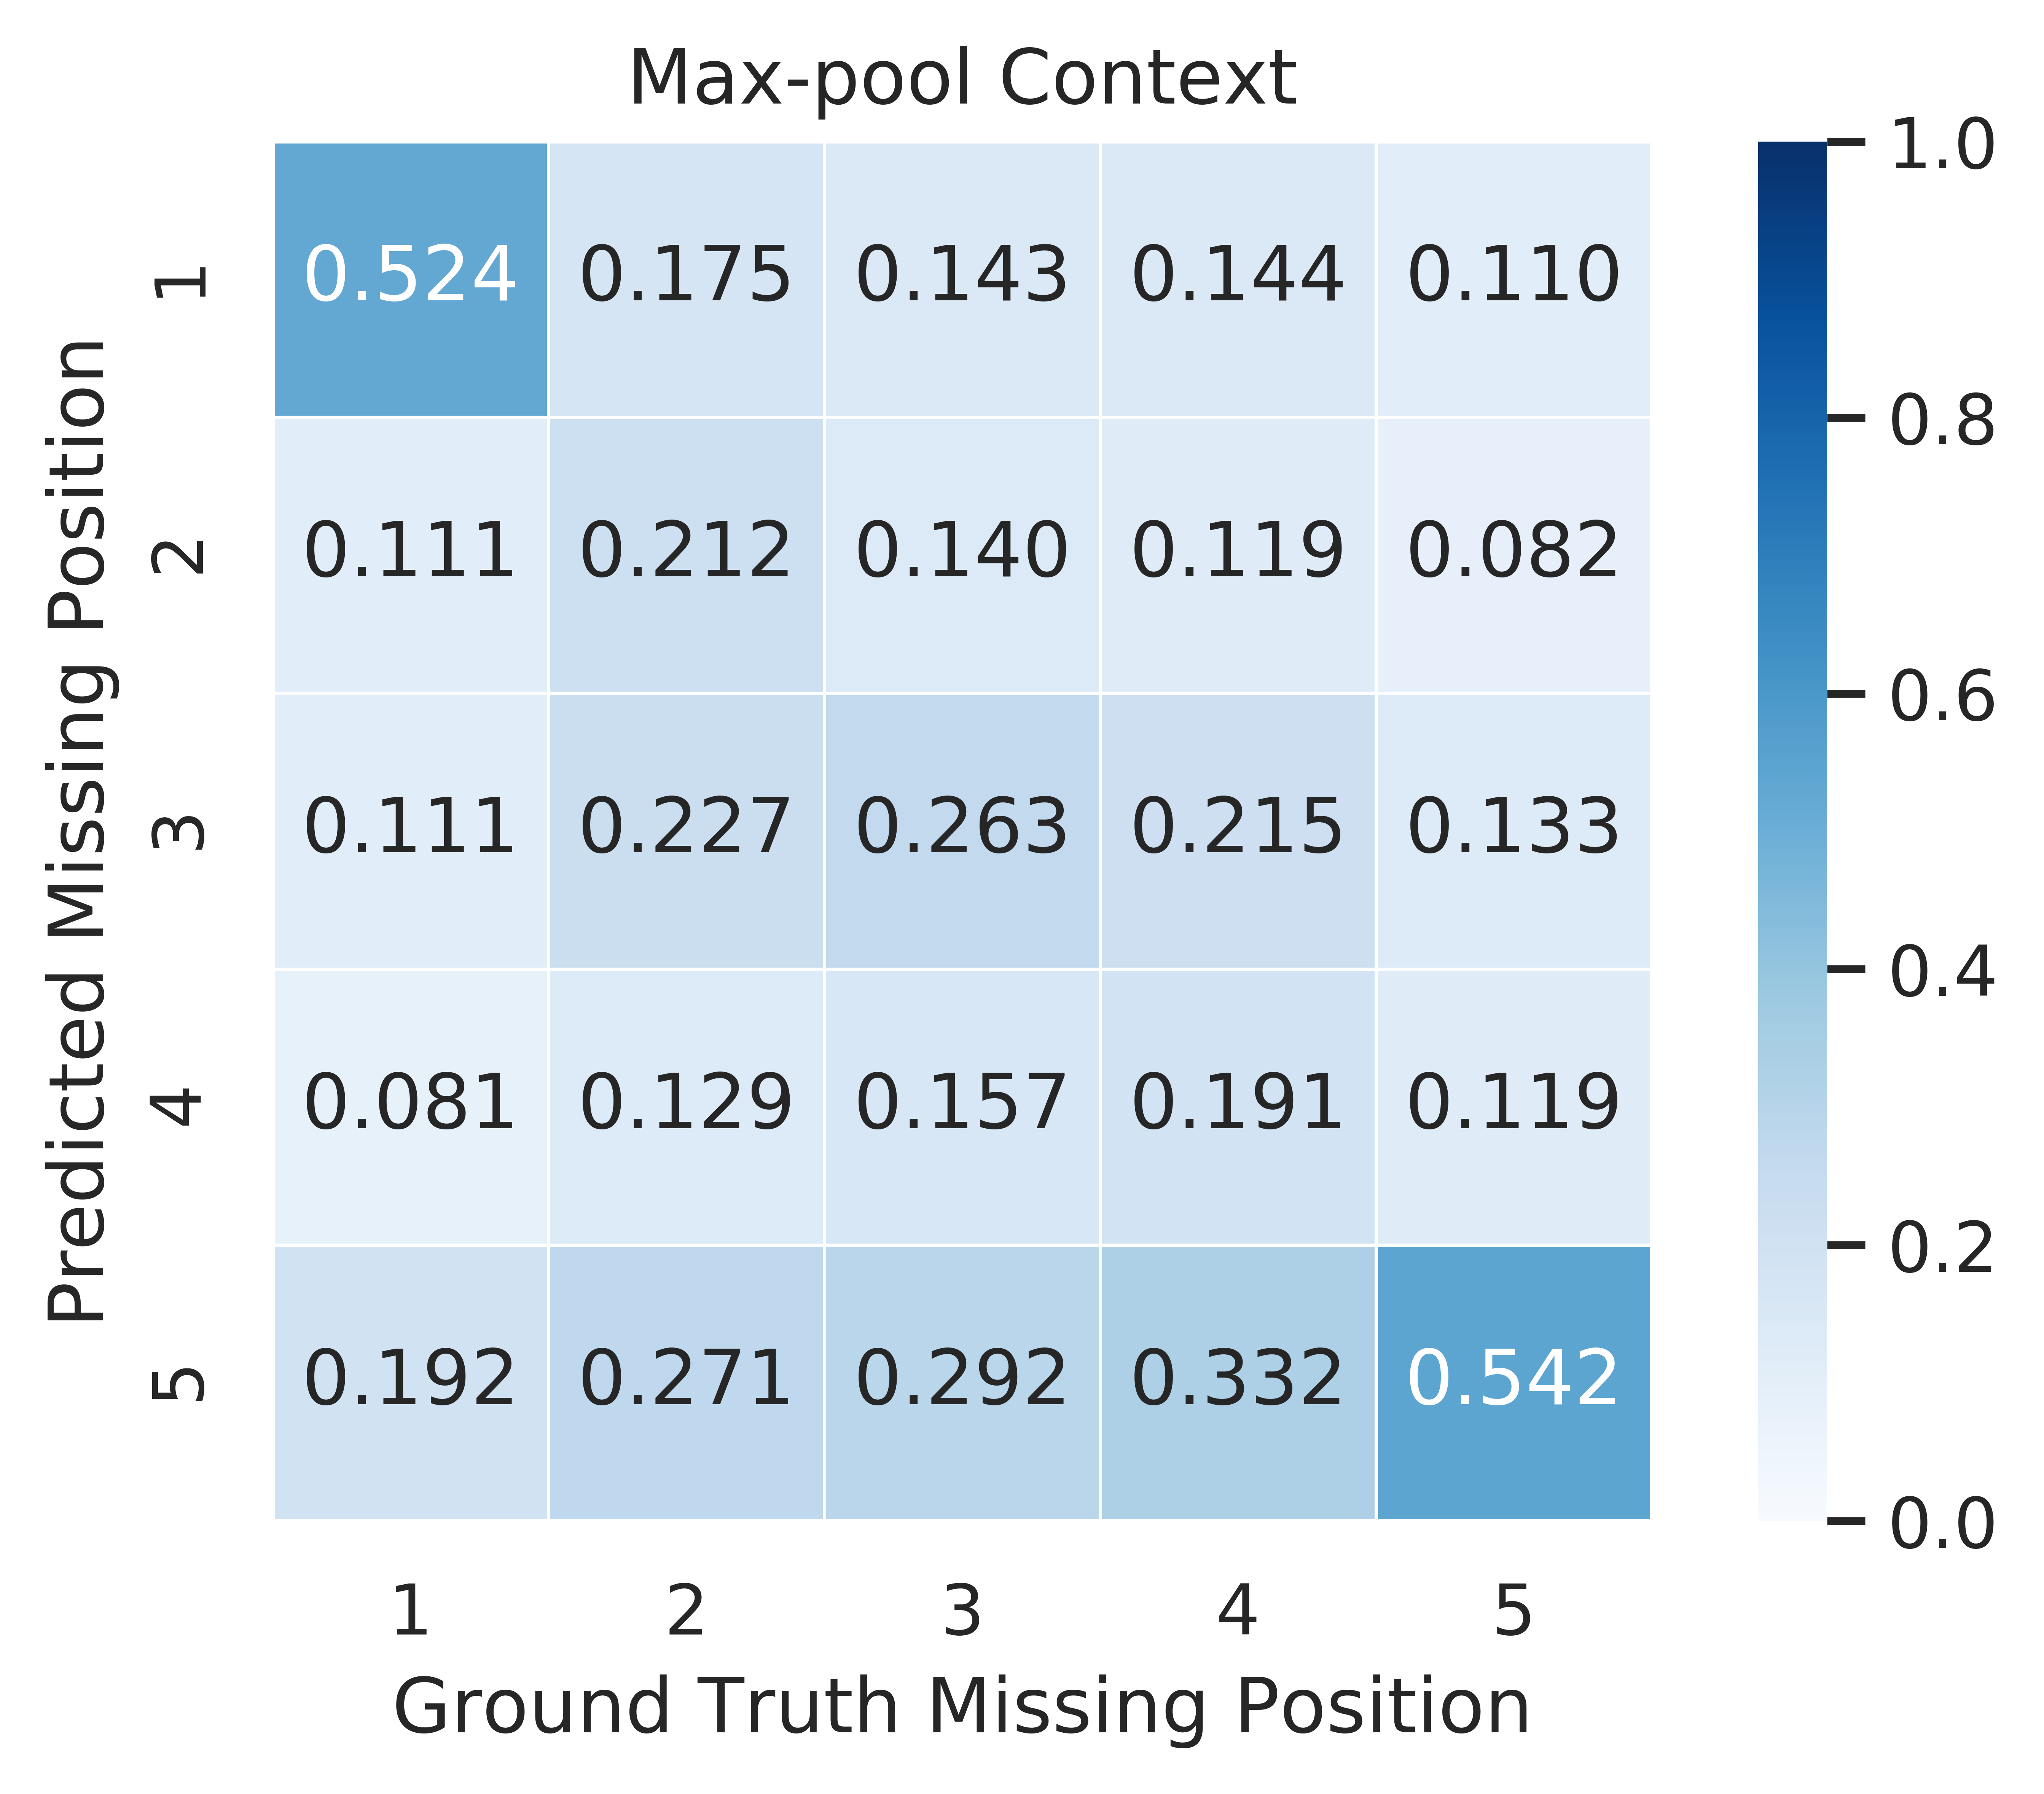

In [14]:
fig = plt.figure(dpi=1200)
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(acc_heatmap_df, cmap="Blues", 
            annot=True, fmt=".3f",
            linewidths=.5, 
            square=True,
            vmin=0.0, vmax=1.0, 
            ax=ax)
ax.set(xlabel ='Ground Truth Missing Position',ylabel='Predicted Missing Position')
#plt.title('Baseline')
plt.title('Max-pool Context')
#plt.savefig('images/mpp_baseline_heatmap.png')
#plt.savefig('images/mpp_heatmap_maxpool.png')
plt.savefig('images/mpp_heatmap_maxpool.eps')
plt.show()

In [11]:
acc_heatmap_df.to_csv("./result/mpp_maxpool_acc_heatmap.csv")